In [1]:
import numpy as np 

In [2]:
import sys
import getopt
import struct

In [3]:
from math import exp

In [4]:
MAX_TIME = 60.0
MAX_TIME_DELTA = 0.5

TEMP_VALUE_CNT = int(MAX_TIME // MAX_TIME_DELTA)

MAX_TEMPERATURE = 850.0
MAX_TEMPERATURE_DELTA = 10.0
HTC_VALUE_CNT = int(MAX_TEMPERATURE // MAX_TEMPERATURE_DELTA) + 1

MAX_CONTROL_POINT_CNT = 5

In [5]:
def load_temp(temp_file, pset=0):
    temp_file.seek(pset * TEMP_VALUE_CNT * 4)
    x = temp_file.read(TEMP_VALUE_CNT * 4)
    temp_vector = struct.unpack('f' * TEMP_VALUE_CNT, x)
    return temp_vector

In [6]:
def load_htc_header(htc_header_file, pset=0):
    htc_header_record_size = MAX_CONTROL_POINT_CNT * 3 + 1
    htc_header_file.seek(pset * htc_header_record_size * 4)
    y = htc_header_file.read(htc_header_record_size * 4)
    floats = struct.unpack('f' * htc_header_record_size, y)

    ''' 
    floats is array of type 
    floats[0] = no of control points. always 5. So we drop it
    floats[1:] = ith control pt temp, ith control pt htc, ith cont pt alpha for all i control pts
    basically 15 + 1 (+1 for floats[0]) no. of values
    '''

    res_arr = []
    for i in range(1, 16, 3):
        tmp_dict = {'temp': floats[i], 'htc': floats[i+1], 'alpha': floats[i+2]}
        res_arr.append(tmp_dict)

    # print('floats', floats)
    return res_arr

In [7]:
def load_htc(htc_data_file, pset=0):
    htc_data_file.seek(pset * HTC_VALUE_CNT * 4)
    x = htc_data_file.read(HTC_VALUE_CNT * 4)
    htc_arr = struct.unpack('f' * HTC_VALUE_CNT, x)
    return htc_arr

In [8]:
def create_htc_value(P_i, P_i_plus_1, T):
    '''
    P_i is control pt before T
    P_i_plus_1 is control pt after T
    C is scaling factor. usually 7
    '''
    C = 7

    alpha_i = P_i['alpha']

    if (alpha_i != 0):
        alpha_i_dash = 1 / (alpha_i * C)
    
    del_T = (T - P_i['temp']) / (P_i_plus_1['temp'] - P_i['temp'])
    
    if (alpha_i != 0):
        gamma_T = (1 - exp(-del_T / alpha_i_dash)) / (1 - exp(-1/alpha_i_dash))

    if (alpha_i != 0):
        HTC_T = P_i['htc'] + gamma_T * (P_i_plus_1['htc'] - P_i['htc'])
    else:
        HTC_T = P_i['htc'] + del_T * (P_i_plus_1['htc'] - P_i['htc'])

    return HTC_T

In [9]:
def create_htc_series(temp_series, htc_headers):
    ptr_htc_1 = 4 # end of htc array
    ptr_htc_2 = 5 # beyond end of htc array

    dummy_last_htc_val = {'temp': 850, 'htc': 0, 'alpha': 0}
    htc_headers.append(dummy_last_htc_val)

    res_arr = []
    for T in temp_series: 
        htc = None
        while True:
            # print(f'ptr1 = {ptr_htc_1}, ptr2 = {ptr_htc_2}', end= ' ')
            # print(f'ptr1.T = {htc_headers[ptr_htc_1]["temp"]}, ptr2.T = {htc_headers[ptr_htc_2]["temp"]}', end= '\n')
            # print(f'T = {T}\n')

            if (ptr_htc_1 < 0):
                break
            elif (T == htc_headers[ptr_htc_1]['temp']):
                htc = htc_headers[ptr_htc_1]['htc']
                break
            elif (T == htc_headers[ptr_htc_2]['temp']):
                htc_headers[ptr_htc_2]['htc']
                break
            elif (T > htc_headers[ptr_htc_1]['temp'] and T < htc_headers[ptr_htc_2]['temp']):
                break
            else:
                if (T < htc_headers[ptr_htc_1]['temp']):
                    ptr_htc_1 -= 1
                    ptr_htc_2 -= 1
                else:
                    ptr_htc_1 += 1
                    ptr_htc_2 += 1


        if (ptr_htc_1 < 0):
            htc = htc_headers[0]['htc']
        elif (ptr_htc_2 > 4):
            htc = htc_headers[4]['htc']
            
        if (not htc):
            P_i = htc_headers[ptr_htc_1]
            P_i_plus_1 = htc_headers[ptr_htc_2]

            htc = create_htc_value(P_i, P_i_plus_1, T)
        
        res_arr.append(htc)

    return res_arr

In [10]:
htc_header_file = open('../Data/test_htc_header.bin', 'rb')

In [11]:
temp_file = open('../Data/test_temp_data.bin', 'rb')

In [12]:
htc_data_file = open('../Data/test_htc_data.bin', 'rb')

In [51]:
temp = load_temp(temp_file, 310)

In [52]:
htc = load_htc(htc_data_file, 310)

In [15]:
#htc

In [53]:
htc_headers = load_htc_header(htc_header_file, 310)

In [56]:
htc_created = create_htc_series(temp, htc_headers)

In [18]:
import matplotlib.pyplot as plt 
%matplotlib inline

In [19]:
def plot_htc(htc_arr):
    Y = htc_arr
    X = x = np.arange(0, 860, 10)

    # Create a figure and axis
    fig, ax = plt.subplots()

    # Plot the data
    ax.plot(X, Y)

    # Set the title and labels
    ax.set_title('HTC History')
    ax.set_xlabel('Temperature')
    ax.set_ylabel('HTC')

    # Show the plot
    plt.show()

In [20]:
def plot_htc2(htc_arr, temp_arr):
    Y = htc_arr
    X = x = temp_arr

    # Create a figure and axis
    fig, ax = plt.subplots()

    # Plot the data
    ax.plot(X, Y)

    # Set the title and labels
    ax.set_title('HTC History')
    ax.set_xlabel('Temperature')
    ax.set_ylabel('HTC')

    # Show the plot
    plt.show()

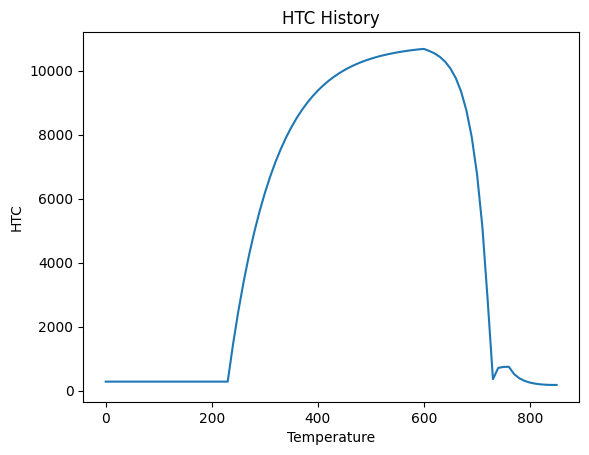

In [54]:
plot_htc(htc)

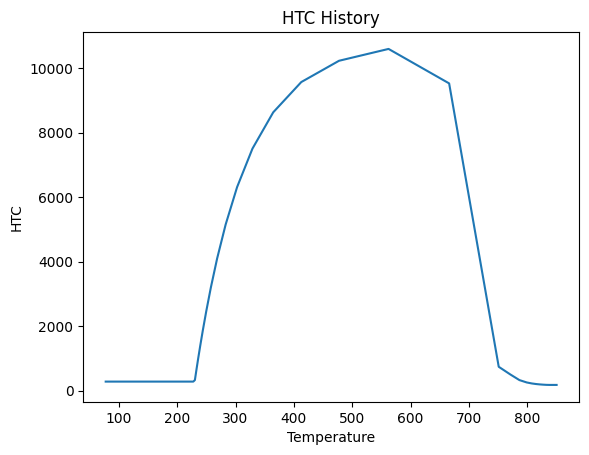

In [57]:

plot_htc2(htc_created, temp)

In [23]:
htc

(414.0,
 414.0,
 414.0,
 414.0,
 414.0,
 414.0,
 414.0,
 414.0,
 414.0,
 414.0,
 414.0,
 414.0,
 414.0,
 414.0,
 414.0,
 414.0,
 414.0,
 414.0,
 414.0,
 414.0,
 414.0,
 414.0,
 414.0,
 414.0,
 414.0,
 414.0,
 414.0,
 414.0,
 414.0,
 414.0,
 414.0,
 1880.2947998046875,
 2764.707763671875,
 3533.380126953125,
 4201.45849609375,
 4782.107421875,
 5286.7685546875,
 5725.38623046875,
 6106.60302734375,
 6437.93115234375,
 6725.8994140625,
 6976.181640625,
 7193.7109375,
 7382.77197265625,
 7547.091796875,
 7689.9072265625,
 7814.03271484375,
 7921.91455078125,
 8015.67822265625,
 8097.1708984375,
 8167.99951171875,
 8229.55859375,
 8283.0615234375,
 8329.5625,
 8369.978515625,
 8405.10546875,
 8435.634765625,
 8452.0,
 4990.90966796875,
 3463.925537109375,
 2436.5625,
 1745.3472900390625,
 1280.2939453125,
 967.403564453125,
 756.8892211914062,
 615.2540893554688,
 519.961181640625,
 455.84759521484375,
 412.7116394042969,
 377.0,
 387.8622741699219,
 403.60504150390625,
 419.61688232421875

In [24]:
import csv

In [25]:
def create_temp_csv(filename, rows):
    with open(filename, mode='w') as csv_file:
        fieldnames = [f'col{x}' for x in range(120)]
        writer = csv.writer(csv_file)
        writer.writerow(fieldnames) # write the header row

        for i in range(rows):
            row = load_temp(temp_file, i) # generate a row of data
            writer.writerow(row) # write the row to the CSV file

In [36]:
def create_htc_120_csv(filename, rows):
    with open(filename, mode='w') as csv_file:
        fieldnames = [f'col{x}' for x in range(120)]
        writer = csv.writer(csv_file)
        writer.writerow(fieldnames) # write the header row

        for i in range(rows):
            htc_headers = load_htc_header(htc_header_file, i)
            temp = load_temp(temp_file, i)
            htc_created = create_htc_series(temp, htc_headers)
            row = htc_created # generate a row of data
            writer.writerow(row) # write the row to the CSV file

In [144]:
create_temp_csv('temp_test.csv', 1000000)

In [37]:
create_htc_120_csv('htc_test.csv', 1000000)

In [27]:
import pandas as pd

In [28]:
df_temp = pd.read_csv('./temp_test.csv')

In [29]:
#df_temp.head()

In [38]:
df_htc = pd.read_csv('./htc_test.csv')

In [31]:
#df_htc.head()

In [32]:
#df_htc.to_numpy()[0]

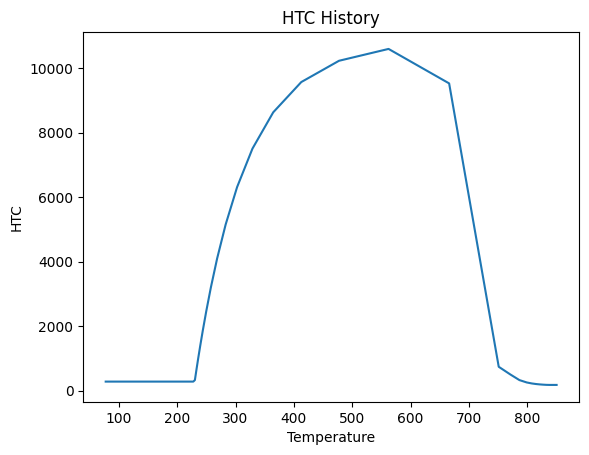

In [58]:
plot_htc2(htc_created, temp)

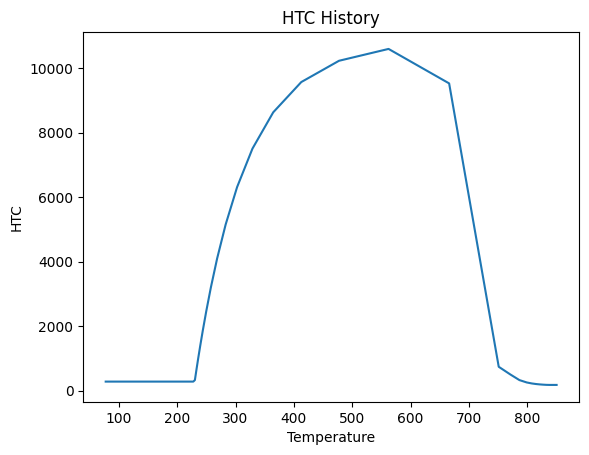

In [59]:
plot_htc2(df_htc.to_numpy()[310], df_temp.to_numpy()[310])

In [41]:
htc_created

[123.0,
 123.0,
 123.0,
 123.0,
 123.0,
 123.0,
 134.23918941052824,
 157.75269953282753,
 194.002226502842,
 262.14849242855064,
 386.13013659919005,
 531.5590260154145,
 508.82135804064995,
 487.5311871132481,
 467.6675306826128,
 449.1261215577088,
 431.78973977993263,
 415.5312335695593,
 400.0609533841539,
 384.51480315989,
 391.00674325893306,
 436.09293650522886,
 801.8353978685109,
 8444.203700191709,
 8127.133546244831,
 7553.738620790053,
 6743.714088419944,
 5792.727265219672,
 4824.361603459944,
 3931.757352931945,
 3163.9634328483776,
 2530.409266510909,
 1982.5661648669213,
 1460.2306164419756,
 931.9285534416917,
 414.0,
 414.0,
 414.0,
 414.0,
 414.0,
 414.0,
 414.0,
 414.0,
 414.0,
 414.0,
 414.0,
 414.0,
 414.0,
 414.0,
 414.0,
 414.0,
 414.0,
 414.0,
 414.0,
 414.0,
 414.0,
 414.0,
 414.0,
 414.0,
 414.0,
 414.0,
 414.0,
 414.0,
 414.0,
 414.0,
 414.0,
 414.0,
 414.0,
 414.0,
 414.0,
 414.0,
 414.0,
 414.0,
 414.0,
 414.0,
 414.0,
 414.0,
 414.0,
 414.0,
 414.0,
 414

In [42]:
df_htc.to_numpy()

array([[123.        , 123.        , 123.        , ..., 414.        ,
        414.        , 414.        ],
       [391.        , 391.        , 391.        , ..., 347.        ,
        347.        , 347.        ],
       [365.        , 365.        , 433.0650075 , ..., 269.        ,
        269.        , 269.        ],
       ...,
       [332.        , 332.        , 332.37330538, ..., 372.        ,
        372.        , 372.        ],
       [251.        , 251.        , 251.        , ..., 416.        ,
        416.        , 416.        ],
       [124.        , 124.        , 124.        , ..., 206.        ,
        206.        , 206.        ]])